In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from mosqlient import get_predictions
from mosqlient.models.score import Scorer
from matplotlib.lines import Line2D
import seaborn as sns
from itertools import product
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 14})

In [2]:
import warnings 
# Ignore all FutureWarnings
warnings.filterwarnings("ignore")

In [3]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)

    data_ = data_.rename(columns = {'date':'dates'})

    #data_.set_index('dates', inplace = True)
    
    return data_

In [4]:
def get_preds(model_id):

    list_of_preds = []
    
    if model_id == 27:

        for p_id in np.arange(250,260):

            print(p_id)
            
            list_of_preds.append(get_predictions(id = int(p_id)))

    elif model_id == 28:

        for p_id in np.arange(260,270):
            
            list_of_preds.append(get_predictions(id = int(p_id)))

    else: 
        list_of_preds = get_predictions(model_id = model_id)


    return list_of_preds 

In [5]:
data = pd.read_csv('data/dengue_uf.csv.gz')

data.head()

,uf,date,casos
0,AC,2010-01-03,869
1,AC,2010-01-10,1003
2,AC,2010-01-17,1010
3,AC,2010-01-24,1397
4,AC,2010-01-31,2000


Defining the peak date:

In [6]:
data_23 = data.loc[(data.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d'))] 
data_24 = data.loc[(data.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d'))] 

In [7]:
peak_dates = {'AM':{2023: {}, 2024: {}}, 'CE': {2023: {}, 2024: {}}, 'GO':{2023: {}, 2024: {}}, 'PR':{2023: {}, 2024: {}}, 'MG':{2023: {}, 2024: {}}}

In [8]:
for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    
    df_23 = data_23.loc[data_23.uf == state]
    
    peak_date = pd.to_datetime(df_23.loc[df_23.casos == df_23['casos'].max()].date.values[0])

    peak_dates[state][2023]['peak_date'] = peak_date

    df_24 = data_24.loc[data_24.uf == state]
    
    peak_date = pd.to_datetime(df_24.loc[df_24.casos == df_24['casos'].max()].date.values[0])

    peak_dates[state][2024]['peak_date'] = peak_date



In [9]:
peak_dates

{'AM': {2023: {'peak_date': Timestamp('2023-02-05 00:00:00')},
  2024: {'peak_date': Timestamp('2024-01-14 00:00:00')}},
 'CE': {2023: {'peak_date': Timestamp('2023-05-07 00:00:00')},
  2024: {'peak_date': Timestamp('2024-04-07 00:00:00')}},
 'GO': {2023: {'peak_date': Timestamp('2023-03-19 00:00:00')},
  2024: {'peak_date': Timestamp('2024-03-10 00:00:00')}},
 'PR': {2023: {'peak_date': Timestamp('2023-04-09 00:00:00')},
  2024: {'peak_date': Timestamp('2024-03-31 00:00:00')}},
 'MG': {2023: {'peak_date': Timestamp('2023-04-09 00:00:00')},
  2024: {'peak_date': Timestamp('2024-02-25 00:00:00')}}}

The cell below fetch the predictions from the API and compute the curve of the scores based on the data:

In [10]:
%%time 
df_score_end  = pd.DataFrame()

for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_preds(model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            preds_id = list_of_preds[idx].id
            df_true = get_cases(data, state)
    
            score = Scorer(df_true = df_true, ids = [preds_id], confidence_level=0.9)

            year = pd.to_datetime(df.dates).dt.year.max()

            score.set_date_range(start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d'),
                                 end_date= Week(year, 40).startdate().strftime('%Y-%m-%d'))

            s1 = score.crps[0][str(preds_id)]
            s2 = score.log_score[0][str(preds_id)]
            s3 = score.interval_score[0][str(preds_id)]
            
            df_score_ = pd.DataFrame()
            df_score_['crps'] = s1
            df_score_['log_score'] = s2
            df_score_['interval_score'] = s3
            df_score_['state'] = state
            df_score_['year'] = year

            if model_id == 26:
                df_score_['model_id'] = 25
            else:
                df_score_['model_id'] = model_id

        
            df_score_end = pd.concat([df_score_end, df_score_])


250
251
252
253
254
255
256
257
258
259
CPU times: user 3.88 s, sys: 221 ms, total: 4.1 s
Wall time: 2min 16s


Checking the shape of the data:

In [11]:
df_score_end.shape

(3035, 6)

Checking for null values:

In [12]:
df_score_end.isnull().sum()

crps              0
log_score         0
interval_score    0
state             0
year              0
model_id          0
dtype: int64

In [13]:
df

,dates,preds,lower,upper,adm_0,adm_1,adm_2,adm_3
0,2023-10-08,453.5,146.00,1664.20,BRA,PR,None,None
1,2023-10-15,500.0,167.00,1771.15,BRA,PR,None,None
2,2023-10-22,522.0,167.00,1790.55,BRA,PR,None,None
3,2023-10-29,577.5,193.00,1948.00,BRA,PR,None,None
4,2023-11-05,645.0,214.95,2211.20,BRA,PR,None,None
5,2023-11-12,715.0,221.95,2447.20,BRA,PR,None,None
6,2023-11-19,764.5,248.95,2616.25,BRA,PR,None,None
7,2023-11-26,827.0,269.00,2913.05,BRA,PR,None,None
8,2023-12-03,870.0,297.85,3018.65,BRA,PR,None,None
9,2023-12-10,924.5,305.80,3177.65,BRA,PR,None,None


In [14]:
rename_models = {30: 'BB-M', 21: 'Dobby data', 25: 'GeoHealth', 
                22: 'Global Health Resilience', 29: 'DS_OKSTATE',
                27: 'Ki-Dengu Peppa model 1', 
                28: 'Ki-Dengu Peppa model 2'}

df_score_end['model'] = df_score_end['model_id'].replace(rename_models)

df_score_end.head()

,crps,log_score,interval_score,state,year,model_id,model
dates,,,,,,,
2022-10-09,31.057032,-5.874705,231.388280,CE,2023,21,Dobby data
2022-10-16,47.792724,-7.897365,508.873115,CE,2023,21,Dobby data
2022-10-23,50.305547,-7.146160,488.208831,CE,2023,21,Dobby data
2022-10-30,40.739151,-6.155401,337.194482,CE,2023,21,Dobby data
2022-11-06,84.733277,-7.967520,731.775521,CE,2023,21,Dobby data


In [15]:
rename_models.values()

dict_values(['BB-M', 'Dobby data', 'GeoHealth', 'Global Health Resilience', 'DS_OKSTATE', 'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2'])

Function to plot the scores for the mandatory states: 

In [26]:
def plot_score(df_score_end, score = 'crps'):

    custom_lines = [Line2D([0], [0], color='black', ls='--')]

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    
    model_legend = ['peak date', 'Dobby data', 'Global Health Resilience', 
                    'GeoHealth', 'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2',
                   'DS_OKSTATE', 'BB-M']
    
    for c in colors: 
    
        custom_lines.append(Line2D([0], [0], color=c, marker='s', linestyle='None', markersize=10))

    if score == 'crps':
        y_title = 'CRPS'
    elif score == 'log_score':
        y_title = 'Log Score'
    elif score == 'interval_score':
        y_title = 'Interval Score'
        
    fig, axs  = plt.subplots(5,2, figsize = (15, 18))
    
    ax =axs.ravel()
    
    i = 0
    for state, year in product(['AM', 'CE', 'GO', 'PR', 'MG'], [2023, 2024]):
    
        df_score_sample = df_score_end.loc[(df_score_end.state == state) & (df_score_end.year == year)].reset_index()

        sns.lineplot(data=df_score_sample, x='dates', y=score, hue='model', palette = colors, hue_order = ['Dobby data', 'Global Health Resilience', 
                    'GeoHealth', 'Ki-Dengu Peppa model 1', 'Ki-Dengu Peppa model 2',
                   'DS_OKSTATE', 'BB-M'], linewidth =1.5, ax=ax[i])

        pd = peak_dates[state][year]['peak_date']
        ax[i].axvline(pd, color = 'black', ls = '--', linewidth = 1.5)
    
        if year == 2023:
            ax[i].legend_.remove()
    
            ax[i].set_ylabel(y_title)
    
        if year == 2024:
            ax[i].set_ylabel('')

            if state == 'AM':
                ax[i].legend(custom_lines, model_legend, title='Model', bbox_to_anchor=(1, 0.525, 0.1, 0.5))
            else:
                ax[i].legend_.remove()
    
        ax[i].set_title(f'{state} - {year}')
    
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
    
        # Rotate the date labels for better readability
        fig.autofmt_xdate(rotation=0, ha='center')
    
        i = i+1
    
    plt.tight_layout()

    plt.subplots_adjust(wspace = 0.25, hspace = 0.15)

    plt.savefig(f'figures/curve_{score}.png', dpi = 600, bbox_inches = 'tight')
    
    plt.show()

Plot the CRPS score: 

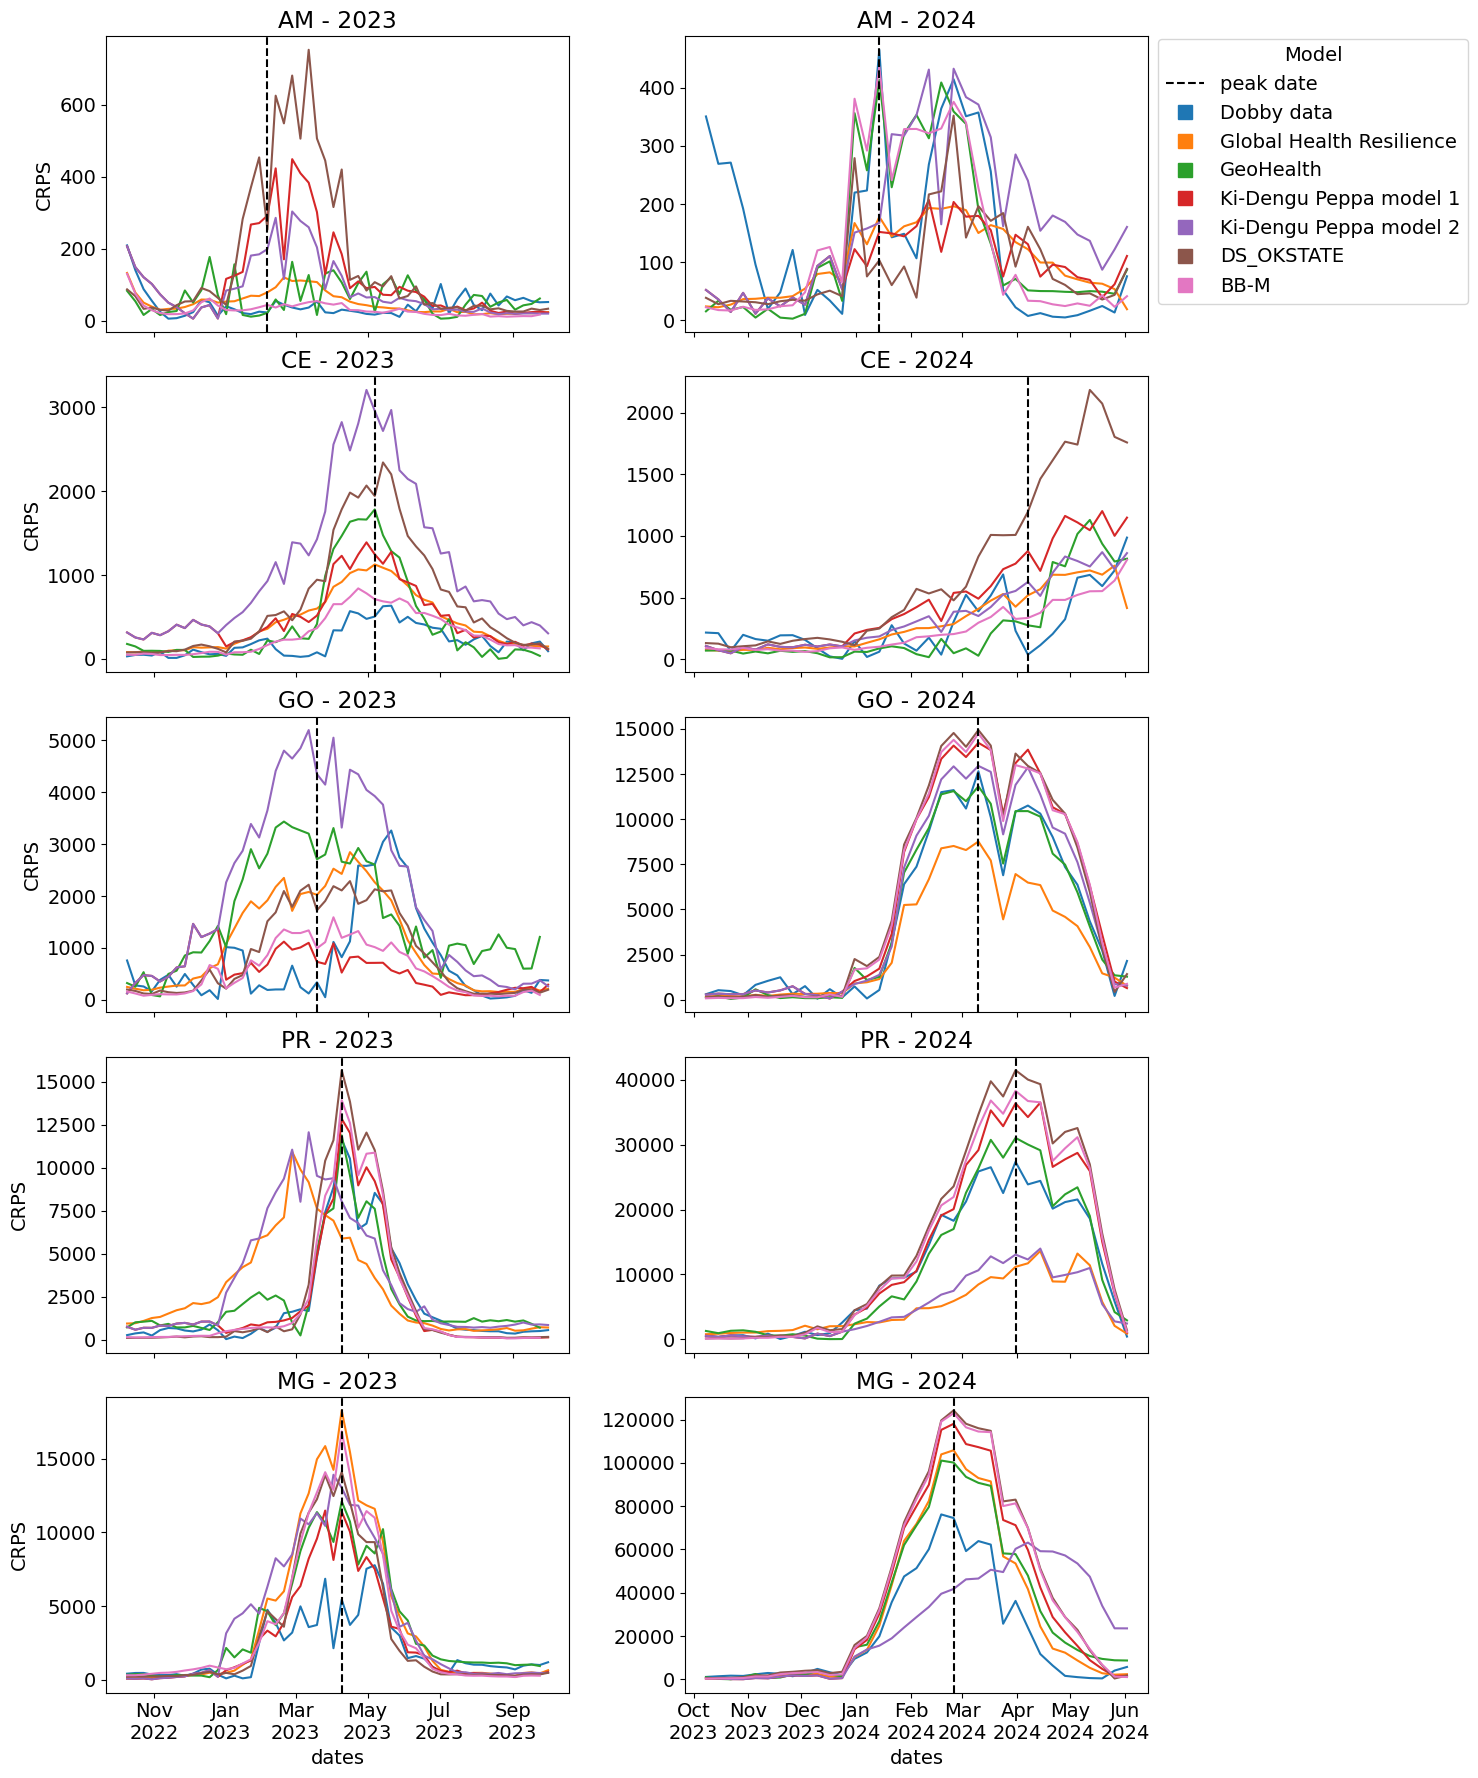

In [27]:
plot_score(df_score_end, score = 'crps')

Plot the Log Score: 

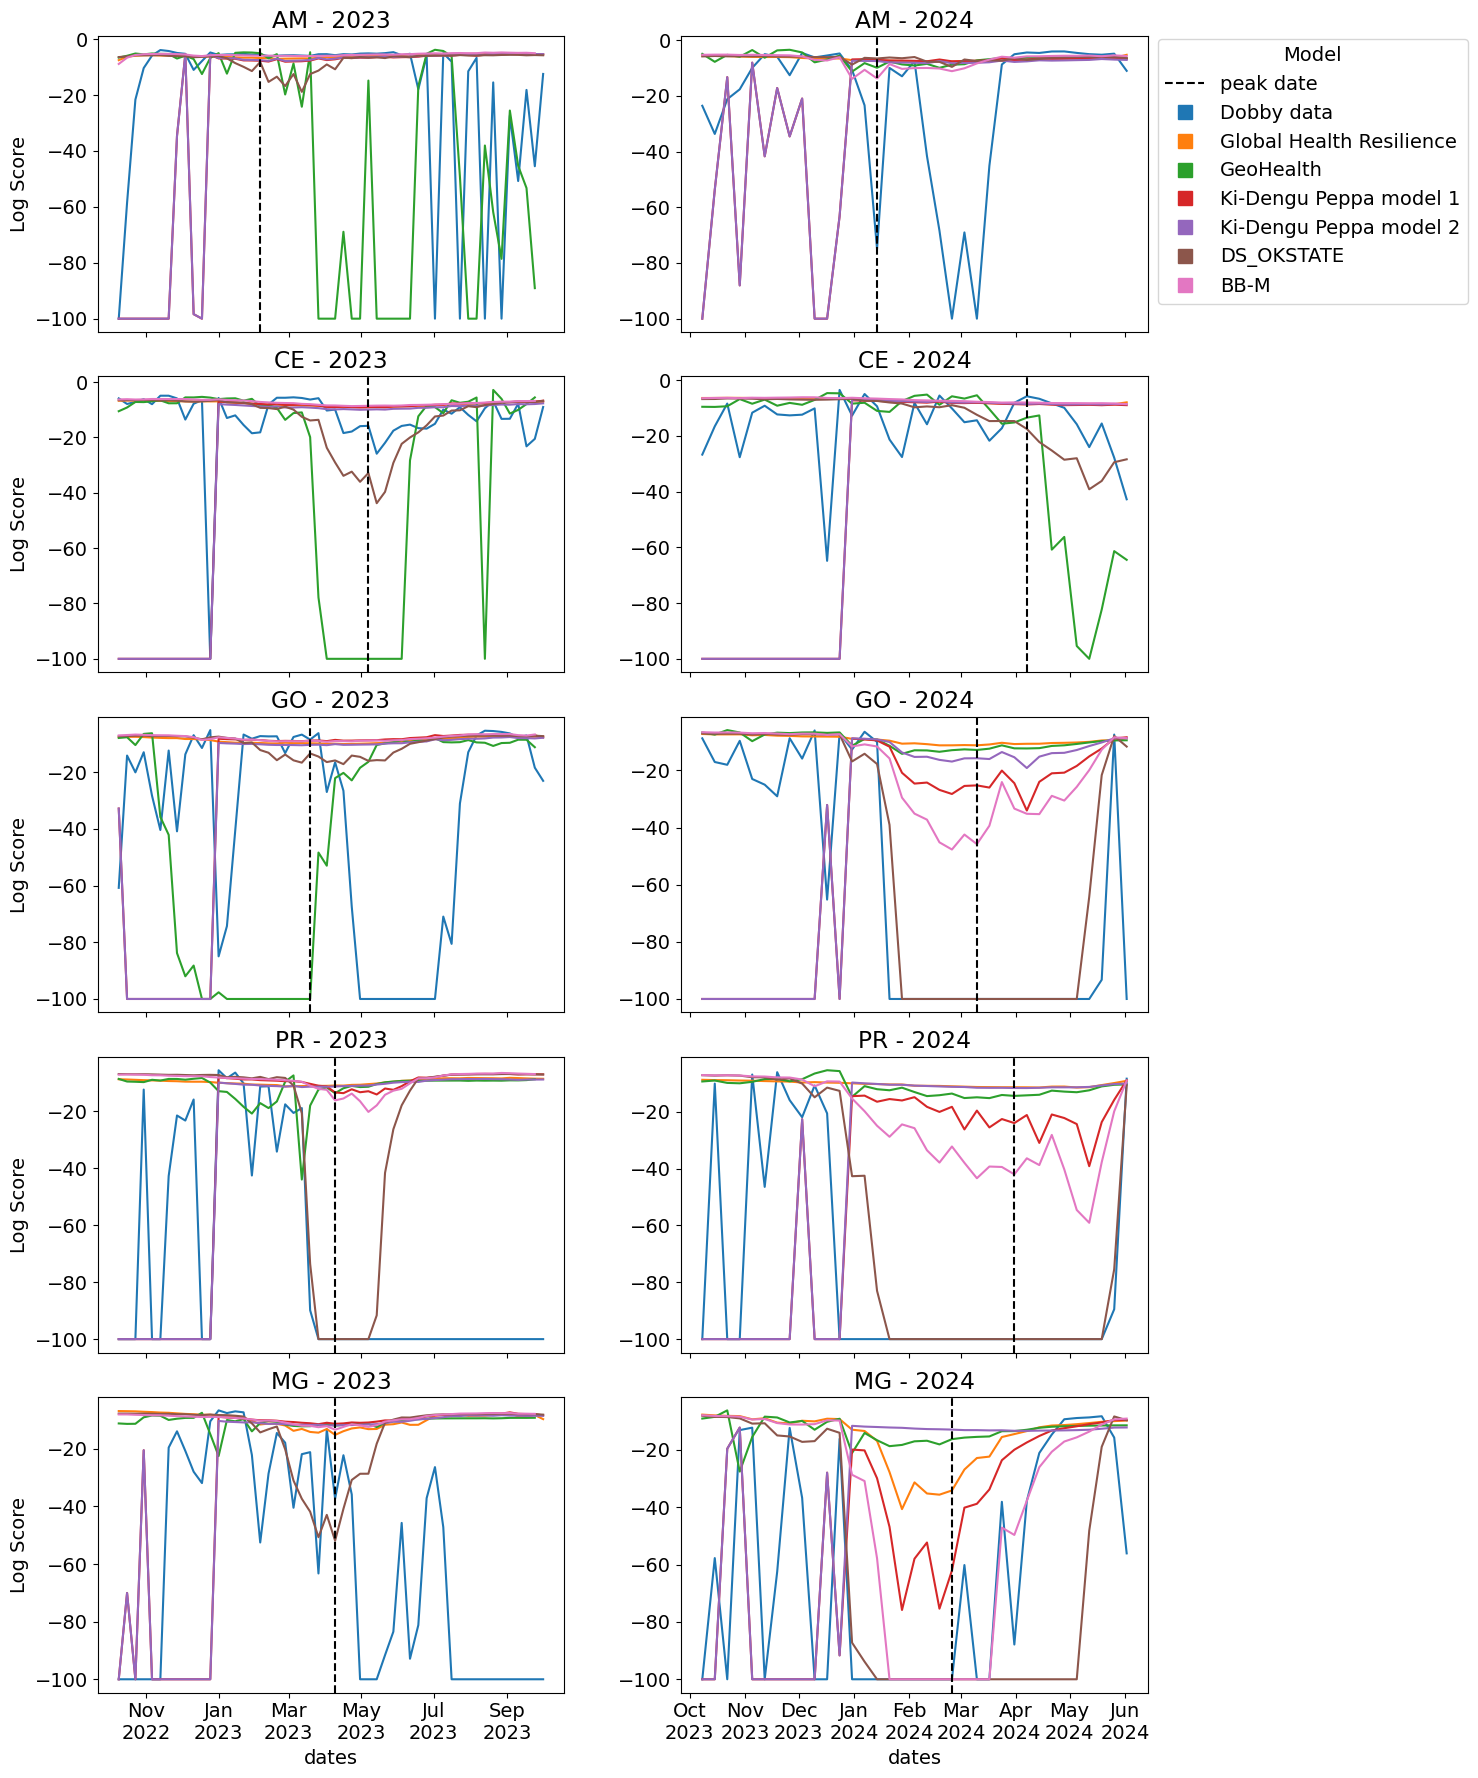

In [28]:
plot_score(df_score_end, score = 'log_score')

Plot the interval score: 

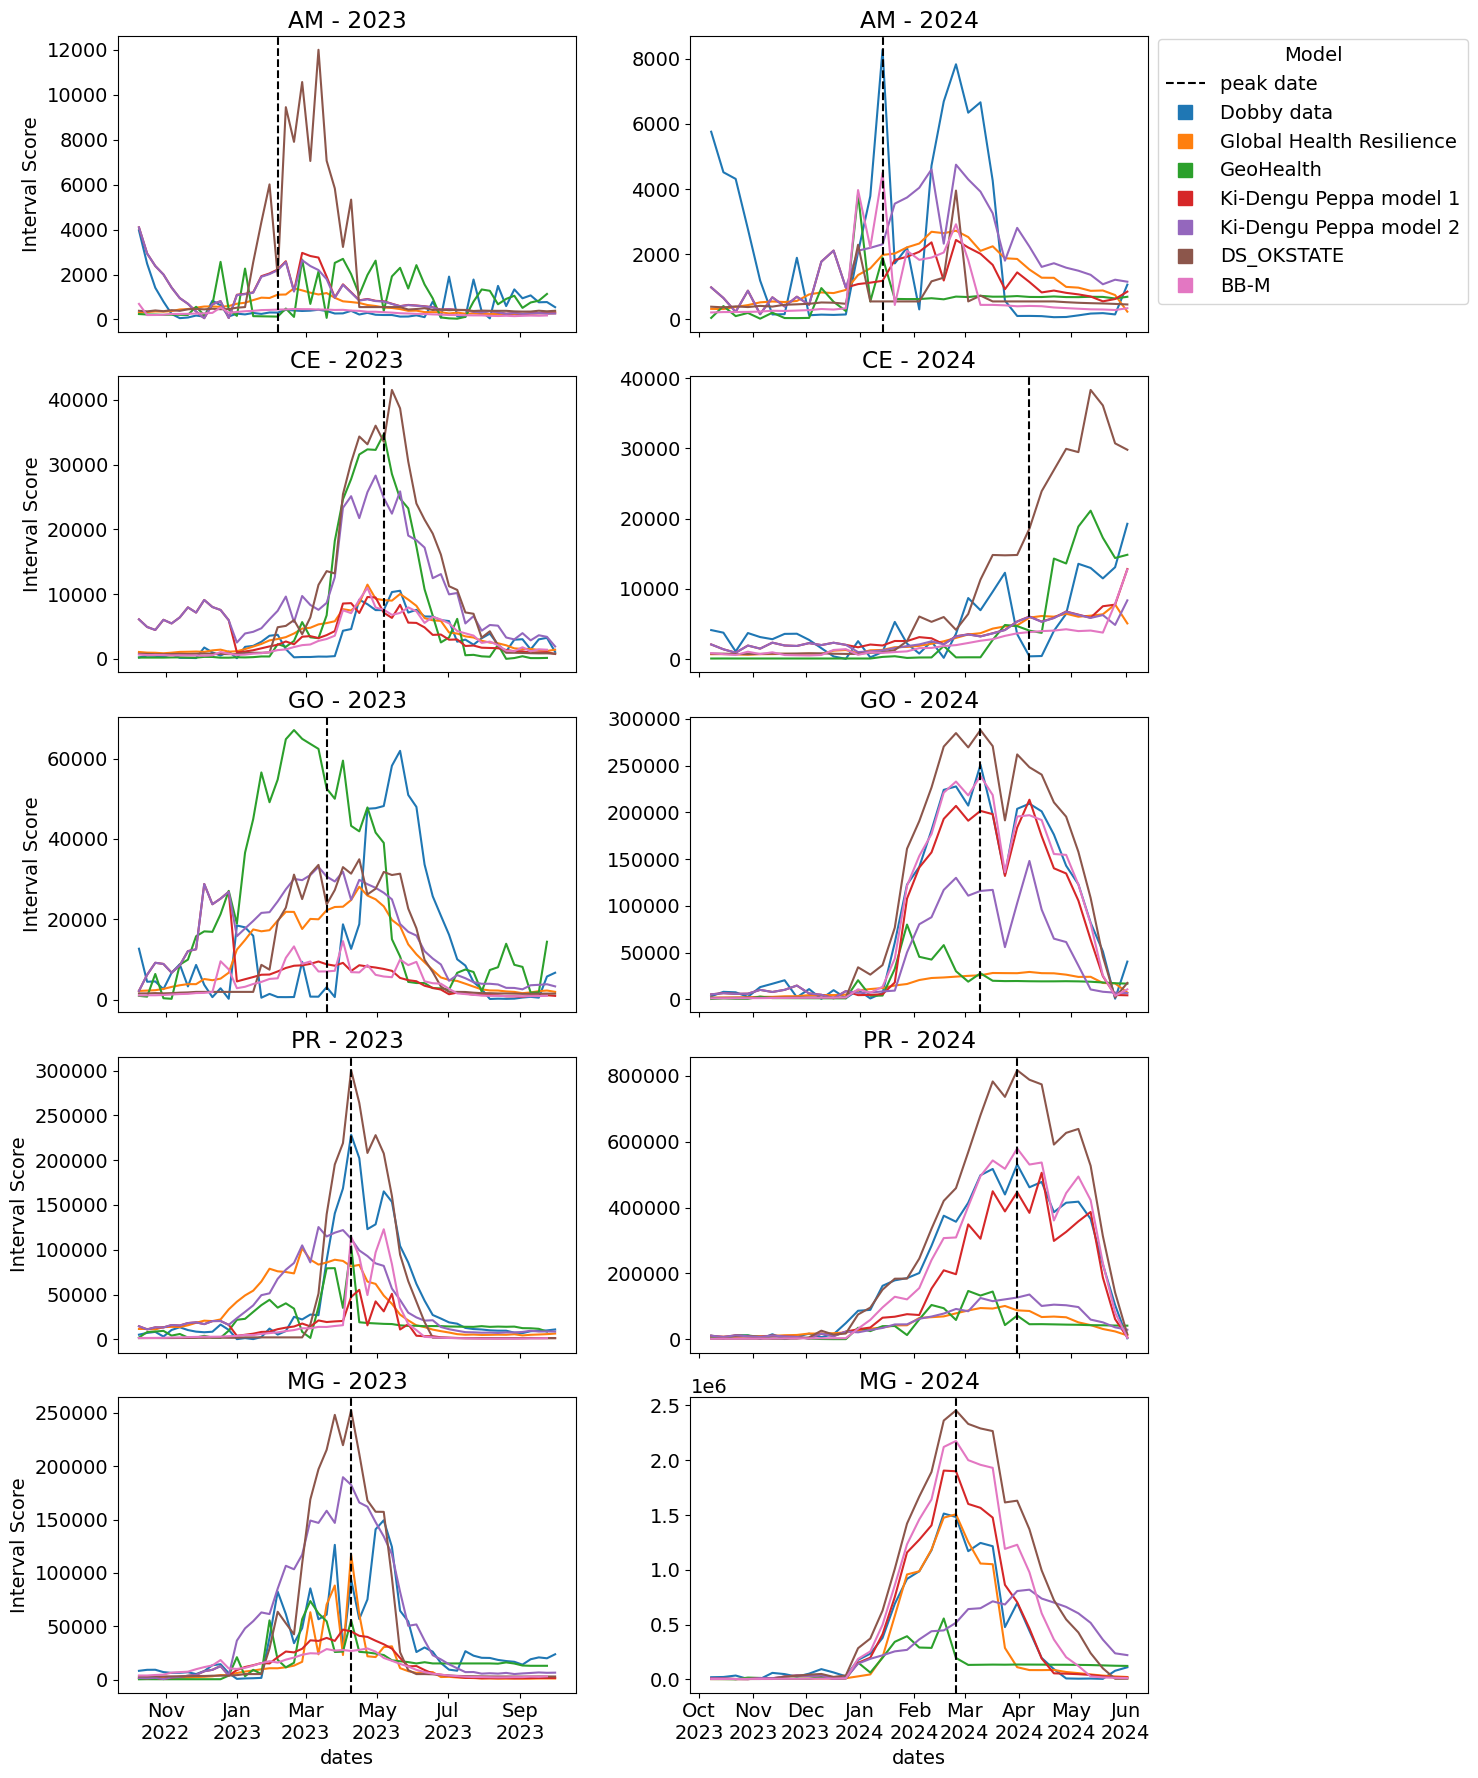

In [29]:
plot_score(df_score_end, score = 'interval_score')